In [261]:
# yahoo finance as data source
import yfinance as yf

In [262]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [263]:
#last 10 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='10y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [264]:
type(data)

pandas.core.frame.DataFrame

In [265]:
data.head()


Price,Close,High,Low,Open,Volume
Ticker,GAIL.NS,GAIL.NS,GAIL.NS,GAIL.NS,GAIL.NS
Date,,,,,
2016-02-16,41.263241,43.348471,41.096936,42.740812,5320818
2016-02-17,41.467922,41.749363,39.382693,41.320804,7745654
2016-02-18,41.371994,42.216319,40.828297,41.806948,7460476
2016-02-19,41.685406,41.826126,40.175853,41.192883,2777987
2016-02-22,41.116119,42.209903,40.700350,41.576660,3622942


In [266]:
len(data)

2471

In [267]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,GAIL.NS,GAIL.NS,GAIL.NS,GAIL.NS,GAIL.NS
Date,,,,,
2026-02-10,164.550003,167.119995,163.699997,163.789993,14629394
2026-02-11,163.470001,164.639999,161.800003,164.639999,8859790
2026-02-12,163.720001,164.500000,162.039993,163.000000,13190080
2026-02-13,161.690002,163.330002,161.119995,162.399994,8523271
2026-02-16,164.820007,165.100006,161.300003,161.679993,10167716


In [268]:
opn = data[['Open']]

<Axes: xlabel='Date'>

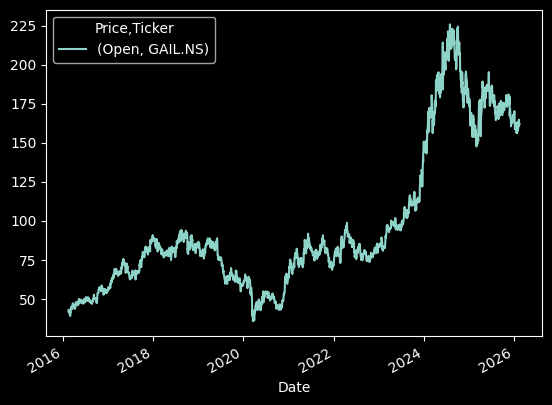

In [269]:

opn.plot()


In [270]:
import matplotlib.pyplot as plt

In [271]:
ds = opn.values

In [272]:
ds

array([[ 42.74081187],
       [ 41.32080435],
       [ 41.80694774],
       ...,
       [163.        ],
       [162.3999939 ],
       [161.67999268]], shape=(2471, 1))

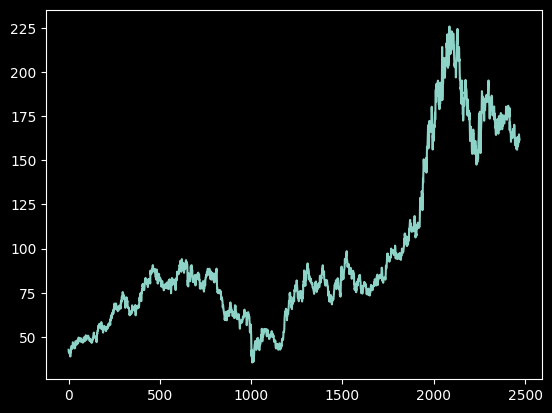

In [273]:
plt.plot(ds)

In [274]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [275]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [276]:
len(ds_scaled), len(ds)

(2471, 2471)

In [277]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [278]:
train_size,test_size

(1729, 742)

In [279]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [280]:
len(ds_train),len(ds_test)

(1729, 742)

In [281]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [282]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [283]:
X_train.shape,y_train.shape

((1628, 100), (1628,))

In [284]:
X_test.shape, y_test.shape

((641, 100), (641,))

In [285]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [286]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
import random
import tensorflow as tf

seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)


In [287]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(64, return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))

d:\STOCK_PRICE_PREDICTION_USING_LSTM\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [288]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [289]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=64,callbacks=[early_stop],shuffle=False)

Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0028 - val_loss: 0.0116
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 6.6209e-04 - val_loss: 0.0070
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.7093e-04 - val_loss: 0.0029
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 8.2225e-04 - val_loss: 0.0012
Epoch 6/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.3536e-04 - val_loss: 0.0036
Epoch 7/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 6.4379e-04 - val_loss: 0.0025
Epoch 8/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 7.9347e-04 - val_loss: 0.0015
Epoch 9/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 5.4945e-04 - val_loss: 0.0020
Epoch 10/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.0840e-04 - val_loss: 0.0043
Epoch 11/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 6.1299e-04 - val_loss: 0.0031
Epoch 12/200
26/

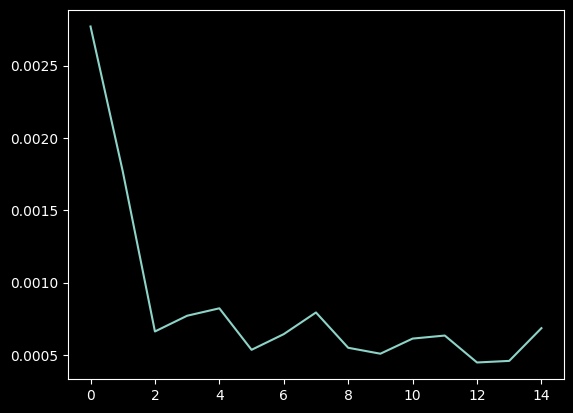

In [290]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

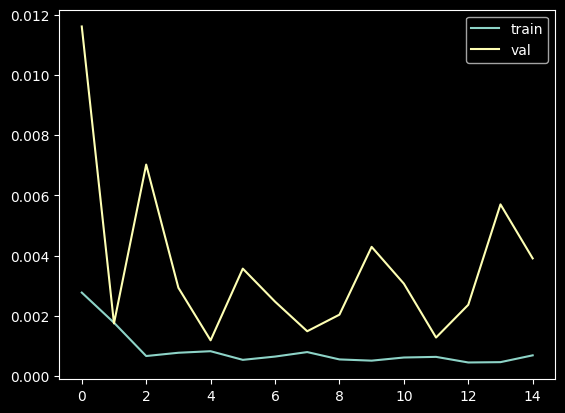

In [291]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'val'])

In [292]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [293]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

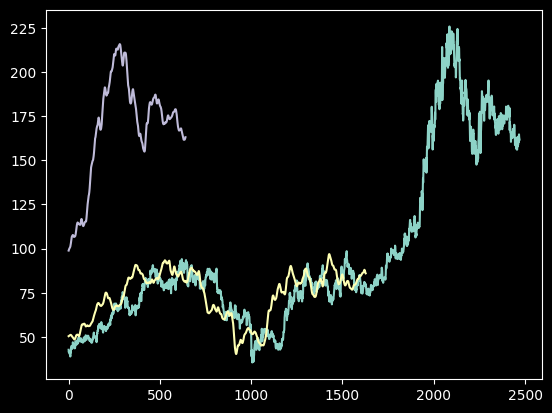

In [294]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [295]:
type(train_predict)


numpy.ndarray

In [296]:
test = np.vstack((train_predict,test_predict))

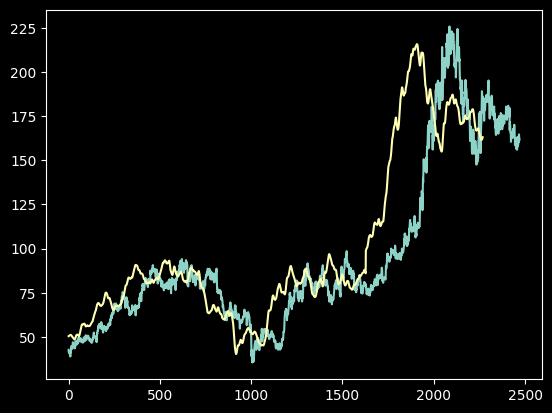

In [297]:

#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [298]:
len(ds_test)

742

In [299]:
#Getting the last 100 days records
fut_inp = ds_test[-100:]

In [300]:
fut_inp = fut_inp.reshape(1,-1)

In [301]:
tmp_inp = list(fut_inp)

In [302]:
fut_inp.shape

(1, 100)

In [303]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [304]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.6733381748199463], [0.6746355891227722], [0.6759673357009888], [0.6773248314857483], [0.6786994934082031], [0.6800846457481384], [0.6814748644828796], [0.6828667521476746], [0.6842567324638367], [0.6856437921524048], [0.6870259642601013], [0.688402533531189], [0.6897727251052856], [0.6911359429359436], [0.6924923062324524], [0.6938410997390747], [0.6951826214790344], [0.6965165734291077], [0.6978426575660706], [0.699161171913147], [0.7004721164703369], [0.7017749547958374], [0.7030697464942932], [0.7043570280075073], [0.7056361436843872], [0.7069072723388672], [0.7081705927848816], [0.7094255089759827], [0.7106728553771973], [0.7119120359420776]]


In [305]:
len(ds_scaled)

2471

In [306]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

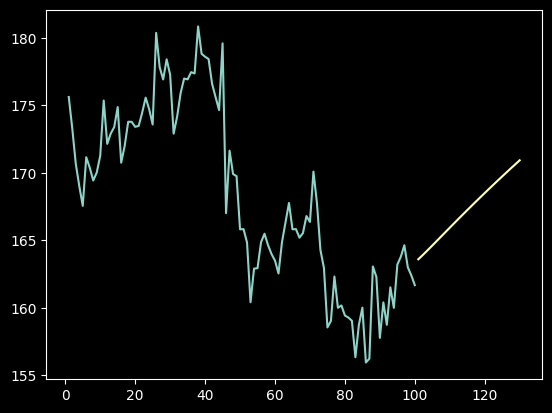

In [307]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[2371:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [308]:
ds_new = ds_scaled.tolist()

In [309]:
len(ds_new)

2471

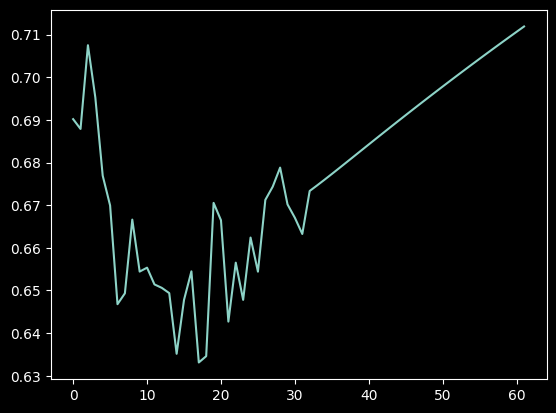

In [310]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[2439:])

In [311]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

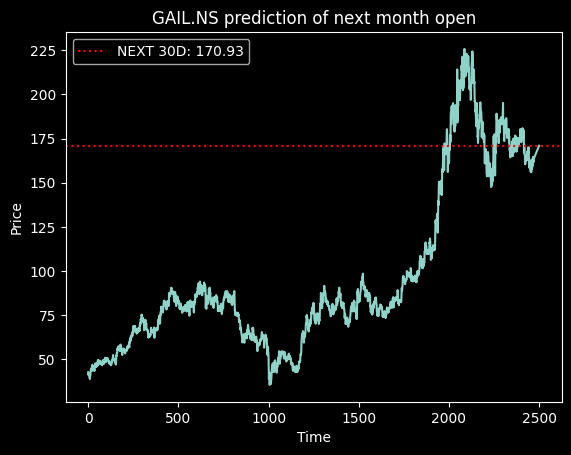

In [312]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

In [313]:
model.save("lstm_model.h5")

import joblib
joblib.dump(normalizer, "scaler.save")


['scaler.save']